In [151]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from empiricaldist import Pmf, Cdf
from matplotlib.ticker import MaxNLocator
%matplotlib inline  
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
# for one hot encoding with feature-engine
from feature_engine.categorical_encoders import OneHotCategoricalEncoder
from feature_engine.categorical_encoders import RareLabelCategoricalEncoder
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

In [152]:
train_data = pd.read_csv("train.csv")

In [153]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [154]:
# imputing missing data as in baseline model

train_data["LotFrontage"] = train_data["LotFrontage"].fillna(train_data["LotFrontage"].median())
train_data["MasVnrArea"] = train_data["MasVnrArea"].fillna(train_data["MasVnrArea"].median())

train_data["MasVnrType"] = train_data["MasVnrType"].fillna(train_data["MasVnrType"].mode())
train_data["Electrical"] = train_data["Electrical"].fillna(train_data["Electrical"].mode())

cat_cols= [x for x in train_data.columns if train_data[x].dtype==np.object]
train_data[cat_cols]=train_data[cat_cols].fillna("NA")
train_data.drop("GarageYrBlt", axis=1, inplace=True)

In [155]:
# transforming some features as in baseline model

train_data[["MoSold", "MSSubClass"]] = train_data[["MoSold", "MSSubClass"]].astype(str)

In [156]:
# Adding two additional engineered features:
#1.Remod: binary feature, 1 if property was remodeled and 0 otherwise
#2.Remod_YrsElapsed: int, number of years since last remodeling refrenced from year of purchase

train_data["Remod"]=0
train_data.loc[train_data["YearBuilt"]!=train_data["YearRemodAdd"], "Remod"]=1
train_data["Remod"].value_counts()/len(train_data)

0    0.523288
1    0.476712
Name: Remod, dtype: float64

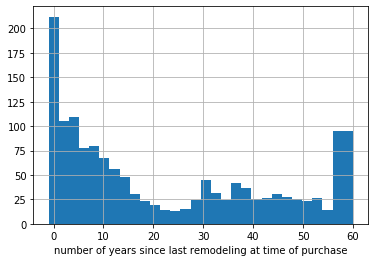

In [157]:
train_data["Remod_YrsElapsed"] = train_data["YrSold"]-train_data["YearRemodAdd"]
train_data["Remod_YrsElapsed"].hist(bins=30)
plt.xlabel("number of years since last remodeling at time of purchase");

In [158]:
# cardinality of each categorical feature 

for column in cat_cols:
    print('Number of categories in the variable {}: {}'.format(column,len(train_data[column].unique())))


Number of categories in the variable MSZoning: 5
Number of categories in the variable Street: 2
Number of categories in the variable Alley: 3
Number of categories in the variable LotShape: 4
Number of categories in the variable LandContour: 4
Number of categories in the variable Utilities: 2
Number of categories in the variable LotConfig: 5
Number of categories in the variable LandSlope: 3
Number of categories in the variable Neighborhood: 25
Number of categories in the variable Condition1: 9
Number of categories in the variable Condition2: 8
Number of categories in the variable BldgType: 5
Number of categories in the variable HouseStyle: 8
Number of categories in the variable RoofStyle: 6
Number of categories in the variable RoofMatl: 8
Number of categories in the variable Exterior1st: 15
Number of categories in the variable Exterior2nd: 16
Number of categories in the variable MasVnrType: 5
Number of categories in the variable ExterQual: 4
Number of categories in the variable ExterCon

In [159]:
# Rare labels encoder

rare_encoder = RareLabelCategoricalEncoder(
    tol=0.05,  # minimal percentage to be considered non-rare
    n_categories=4, # minimal number of categories the variable should have to re-cgroup rare categories
) 

rare_encoder.fit(train_data)
train_data = rare_encoder.transform(train_data)

In [160]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 82 columns):
Id                  1460 non-null int64
MSSubClass          1460 non-null object
MSZoning            1460 non-null object
LotFrontage         1460 non-null float64
LotArea             1460 non-null int64
Street              1460 non-null object
Alley               1460 non-null object
LotShape            1460 non-null object
LandContour         1460 non-null object
Utilities           1460 non-null object
LotConfig           1460 non-null object
LandSlope           1460 non-null object
Neighborhood        1460 non-null object
Condition1          1460 non-null object
Condition2          1460 non-null object
BldgType            1460 non-null object
HouseStyle          1460 non-null object
OverallQual         1460 non-null int64
OverallCond         1460 non-null int64
YearBuilt           1460 non-null int64
YearRemodAdd        1460 non-null int64
RoofStyle           1460 non-null obj

In [161]:
# evaluating new model

X = train_data.drop(["Id", "SalePrice"], axis=1)
y = train_data["SalePrice"]

In [162]:
lightgbm_regr = LGBMRegressor(lambda_l1=1)
scores = cross_val_score(lightgbm_regr, X, y, cv=10, scoring='neg_mean_squared_log_error')
scores = np.sqrt(np.abs(scores))
print("RMSLE: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

RMSLE: nan (+/- nan)


/Users/dina/house-prices-advanced/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: DataFrame.dtypes for data must be int, float or bool.
Did not expect the data types in the following fields: MSSubClass, MSZoning, Street, Alley, LotShape, LandContour, Utilities, LotConfig, LandSlope, Neighborhood, Condition1, Condition2, BldgType, HouseStyle, RoofStyle, RoofMatl, Exterior1st, Exterior2nd, MasVnrType, ExterQual, ExterCond, Foundation, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2, Heating, HeatingQC, CentralAir, Electrical, KitchenQual, Functional, FireplaceQu, GarageType, GarageFinish, GarageQual, GarageCond, PavedDrive, PoolQC, Fence, MiscFeature, MoSold, SaleType, SaleCondition

  warnings.warn("Estimator fit failed. The score on this train-test"


In [163]:
print(scores)

[nan nan nan nan nan nan nan nan nan nan]


In [164]:
rf_regr = RandomForestRegressor()
scores = cross_val_score(rf_regr, X, y, cv=10, scoring='neg_mean_squared_log_error')
scores = np.sqrt(np.abs(scores))
print("RMSLE: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

RMSLE: nan (+/- nan)


/Users/dina/house-prices-advanced/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: could not convert string to float: 'Rare'

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/dina/house-prices-advanced/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: could not convert string to float: 'Rare'

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/dina/house-prices-advanced/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:532: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: could not convert

In [165]:
print(scores)

[nan nan nan nan nan nan nan nan nan nan]
